In [1]:
import matplotlib.pyplot as plt
from HARK.utilities import plotFuncs
from time import process_time
import numpy as np
from HARK.ConsumptionSaving.ConsPrefShockModel import (
    PrefShockConsumerType,
    KinkyPrefConsumerType,
)
mystr = lambda number: "{:.4f}".format(number)
do_simulation = True

This module defines consumption-saving models in which agents have CRRA utility over a unitary consumption good, geometric discounting, who face idiosyncratic shocks to income and to their utility or preferences. That is, this module contains models that extend $\texttt{ConsIndShockModel}$ with preference shocks.

$\texttt{ConsPrefShockModel}$ currently solves two types of models:
1. An extension of $\texttt{ConsIndShock}$, but with an iid lognormal multiplicative shock each period.
2. A combination of (1) and $\texttt{ConsKinkedR}$, demonstrating how to construct a new model
   by inheriting from multiple classes.

### Multiplicative Shocks to Utility

In this model, an agent is very similar to the one in the "idiosyncratic shocks" model, except that in $\texttt{ConsPrefShockModel}$ an agent receives an iid multiplicative shock to his/her utility at the beginning of each period, before making the consumption decision. 

The agent's problem can be written in (normalized) Bellman form as:

\begin{eqnarray*}
v_t(m_t,\eta_t) &=& \max_{c_t} u(\eta_t.c_t) + \beta (1-\mathsf{D}_{t+1}) \mathbb{E} [(\Gamma_{t+1}\psi_{t+1})^{1-\rho} v_{t+1}(m_{t+1}, \eta_{t+1}) ], \\
a_t &=& m_t - c_t, \\
a_t &\geq& \underline{a}, \\
m_{t+1} &=& R/(\Gamma_{t+1}\psi_{t+1}) a_t + \theta_{t+1}, \\
\psi_{t},\theta_{t} \sim F_{t}, &\qquad& \mathbb{E} [F_{\psi t}] = 1, \\
u(c) &=& \frac{c^{1-\rho}}{1-\rho}, \eta_t \sim F_{\eta t}
\end{eqnarray*}


The one period problem for this model is solved by the function $\texttt{solveConsPrefShock}$, which creates an instance of the class $\texttt{ConsPrefShockSolver}$. The class $\texttt{PrefShockConsumerType}$ extends $\texttt{IndShockConsumerType}$ to represents agents in this model. 

To construct an instance of this class, 3 additional attributes must be passed to the constructor as shown in the table below (parameters can be either "primitive" if they are directly specified by the user or "constructed" if they are built by a class method using simple parameters specified by the user).

### Additional parameter values to solve an instance of PrefShockConsumerType

| Param | Description | Code | Value | Constructed |
| :---: | --- | --- | --- | :---: |
| $N{\eta}$ |Number of discrete points in "body" of preference shock distribution  | $\texttt{PerfShkCount}$ | 12 |$\surd$ |
| $N{\eta}$ |Number of discrete points in "tails" of preference shock distribution  | $\texttt{PrefShk_tail_N}$ |4|$\surd$ |
| $\sigma_{\eta}$ |Log standard deviation of multiplicative utility shocks  | $\texttt{PerfShkStd}$ | [0.30] |$\surd$ |



### Constructed inputs to solve ConsPrefShockModel

* The tails of the preference shock distribution are of great importance for the accuracy of the solution and are underrepresented by the default equiprobable discrete approximation (unless a very large number of points are used). 
To fix this issue, the attribute $\texttt{PerfShk_tail_N}$ specifies the number of points in each " augmented tail" section of the preference shock discrete approximation. 
See [HARK.utilities.approxLognormal](https://github.com/econ-ark/HARK/blob/master/HARK/utilities.py) for more details.


* The standard deviation of preference shocks might vary by period. Therefore, $\texttt{PerShkStd}$ should be input as a list.

Note that the $\texttt{solve}$ method of $\texttt{PerfShockConsumerType}$ populates the $\texttt{solution}$ with a list of $\texttt{ConsumerSolution}$ instances. These single-period-solution objects have the same attributes as the "idiosyncratic shocks" model, but the attribute $\texttt{cFunc}$ is defined over the space of ($m_{t}$, $\eta_{t}$) rather than just $m_{t}$.

The value function $\texttt{vFunc}$ and marginal value $\texttt{vPfunc}$, however, are defined *only* over $m_{t}$, as they represent expected (marginal) value *just before* the preference shock $\eta_{t}$ is realized.

In [2]:
# Make and solve a preference shock consumer
PrefShockExample = PrefShockConsumerType()
PrefShockExample.cycles = 0  # Infinite horizon

In [3]:
t_start = process_time()
PrefShockExample.solve()
t_end = process_time()
print("Solving a preference shock consumer took " + str(t_end - t_start) + " seconds.")

Solving a preference shock consumer took 0.7070743499999996 seconds.


Consumption functions at each discrete shock:


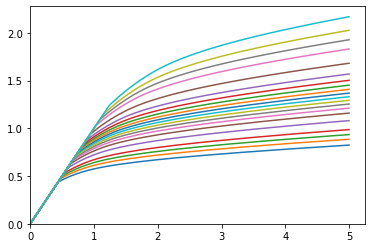

In [4]:
# Plot the consumption function at each discrete shock
m = np.linspace(PrefShockExample.solution[0].mNrmMin, 5, 200)
print("Consumption functions at each discrete shock:")
for j in range(PrefShockExample.PrefShkDstn[0].pmf.size):
    PrefShk = PrefShockExample.PrefShkDstn[0].X[j]
    c = PrefShockExample.solution[0].cFunc(m, PrefShk * np.ones_like(m))
    plt.plot(m, c)
plt.xlim([0.0, None])
plt.ylim([0.0, None])
plt.show()

Consumption function (and MPC) when shock=1:


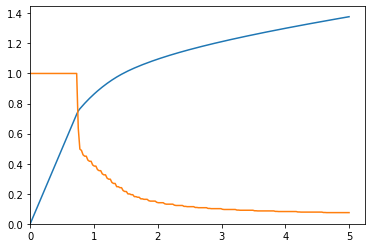

In [5]:
print("Consumption function (and MPC) when shock=1:")
c = PrefShockExample.solution[0].cFunc(m, np.ones_like(m))
k = PrefShockExample.solution[0].cFunc.derivativeX(m, np.ones_like(m))
plt.plot(m, c)
plt.plot(m, k)
plt.xlim([0.0, None])
plt.ylim([0.0, None])
plt.show()

In [6]:
if PrefShockExample.vFuncBool:
    print("Value function (unconditional on shock):")
    plotFuncs(
        PrefShockExample.solution[0].vFunc,
        PrefShockExample.solution[0].mNrmMin + 0.5,
        5,
    )

In [7]:
# Test the simulator for the pref shock class
if do_simulation:
    PrefShockExample.T_sim = 120
    PrefShockExample.track_vars = ["cNrm"]
    PrefShockExample.make_shock_history()  # This is optional
    PrefShockExample.initialize_sim()
    PrefShockExample.simulate()

### Utility Shocks and Different Interest Rates

In this model, an agent face idiosyncratic shocks to permanent and transitory income and multiplicative shocks to utility *and* faces a different interst rate on borrowing vs saving. This agent's model is identical to that of the $\texttt{ConsPrefShockModel}$ with the addition of the interst rate rule from the $\texttt{kinkedRConsumerType}$ from $\texttt{ConsIndShock}$ model.

The one period problem of this model is solved by the function $\texttt{solveConsKinkyPref}$, which creates an instance of $\texttt{ConsKinkyPrefSolver}$. The class $\texttt{KinkyPrefConsumerType}$ represents agents in this model. 

Thanks to HARK's object-oriented approach to solution methods, it is trivial to combine two models to make a new one. In this current case, the solver and consumer classes each inherit from both $\texttt{KinkedR}$ and $\texttt{PrefShock}$ and only need a trivial constructor function to rectify the differences between the two.



### Constructed inputs to solve KinkyPref

* The attributes required to properly construct an instance of $\texttt{KinkyPrefConsumerType}$ are the same as $\texttt{PrefShockConsumerType}$, except that $\texttt{Rfree}$ should not be replace with $\texttt{Rboro}$ and $\texttt{Rsave}$ - like the "kinked R" parent model. 

* Also, as in $\texttt{KinkedR}$ and $\texttt{PrefShock}$, $\texttt{KinkyPref}$ is not yet compatible with cubic spline interpolation of the consumption function. 

In [8]:
# Make and solve a "kinky preferece" consumer, whose model combines KinkedR and PrefShock
KinkyPrefExample = KinkyPrefConsumerType()
KinkyPrefExample.cycles = 0  # Infinite horizon

In [9]:
t_start = process_time()
KinkyPrefExample.solve()
t_end = process_time()
print("Solving a kinky preference consumer took " + str(t_end - t_start) + " seconds.")

Solving a kinky preference consumer took 0.8237398380000007 seconds.


Consumption functions at each discrete shock:


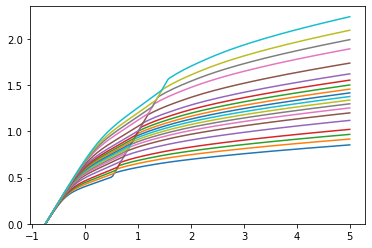

In [10]:
# Plot the consumption function at each discrete shock
m = np.linspace(KinkyPrefExample.solution[0].mNrmMin, 5, 200)
print("Consumption functions at each discrete shock:")
for j in range(KinkyPrefExample.PrefShkDstn[0].X.size):
    PrefShk = KinkyPrefExample.PrefShkDstn[0].X[j]
    c = KinkyPrefExample.solution[0].cFunc(m, PrefShk * np.ones_like(m))
    plt.plot(m, c)
plt.ylim([0.0, None])
plt.show()

Consumption function (and MPC) when shock=1:


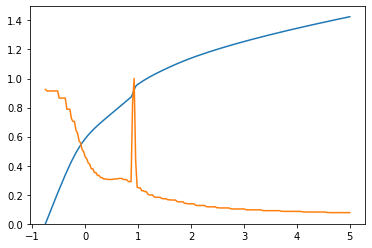

In [11]:
print("Consumption function (and MPC) when shock=1:")
c = KinkyPrefExample.solution[0].cFunc(m, np.ones_like(m))
k = KinkyPrefExample.solution[0].cFunc.derivativeX(m, np.ones_like(m))
plt.plot(m, c)
plt.plot(m, k)
plt.ylim([0.0, None])
plt.show()

In [12]:
if KinkyPrefExample.vFuncBool:
    print("Value function (unconditional on shock):")
    plotFuncs(
        KinkyPrefExample.solution[0].vFunc,
        KinkyPrefExample.solution[0].mNrmMin + 0.5,
        5,
    )

In [13]:
# Test the simulator for the kinky preference class
if do_simulation:
    KinkyPrefExample.T_sim = 120
    KinkyPrefExample.track_vars = ["cNrm", "PrefShk"]
    KinkyPrefExample.initialize_sim()
    KinkyPrefExample.simulate()

/home/sb/projects/econ-ark/HARK/HARK/core.py:853: RuntimeWarning: invalid value encountered in add
  self.history[var_name] = np.empty((self.T_sim, self.AgentCount)) + np.nan
